In [6]:
import pandas as pd

# Load your S&P 500 data
# Replace 'your_data.csv' with your actual file
# Ensure the file has a 'Close' column for the prices
df = pd.read_csv('new_S&P500ShortTerm-raw_prices.csv', parse_dates=['Datetime'])
#df.sort_values('Timestamp', inplace=True)

# Calculate percentage change
df['Pct_Change'] = df['Close'].pct_change() * 100

# Define labeling function
def label_data(pct_change):
    if pct_change >= 0.5:
        return 'Strong Buy'
    elif pct_change < 0.5 and pct_change >= 0.25:
        return 'Buy'
    elif pct_change <= -0.25 and pct_change > -0.5:
        return 'Sell'
    elif pct_change <= -0.5:
        return 'Strong Sell'
    else:
        return 'Keep'

# Apply labeling
df['Label'] = df['Pct_Change'].apply(label_data)

# Remove rows with NaN due to pct_change
df = df.dropna()

# Save labeled data to a new CSV
df.to_csv('labeled_sp500_data.csv', index=False)

# Display labeled data
#import ace_tools as tools; tools.display_dataframe_to_user(name="Labeled S&P 500 Data", dataframe=df)


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Load the labeled data
df = pd.read_csv('labeled_sp500_data.csv')

# Features (X) and Target (y)
# Use relevant numerical columns as features
features = ['Close', 'Pct_Change']  # Adjust based on your dataset
X = df[features]
y = df['Label']

# Encode target labels to integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 'Buy' -> 0, 'Sell' -> 1, 'Keep' -> 2

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM Model
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Make Predictions
y_pred = svm_model.predict(X_test_scaled)

# Evaluate Model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Save the trained model
import joblib
joblib.dump(svm_model, 'svm_sp500_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Model and encoders saved successfully.")


Confusion Matrix:
[[ 52   7   0   1   0]
 [  0 480   0   0   0]
 [  0   1  52   0   0]
 [  0   0   0  19   0]
 [  0   0   0   0  27]]

Classification Report:
              precision    recall  f1-score   support

         Buy       1.00      0.87      0.93        60
        Keep       0.98      1.00      0.99       480
        Sell       1.00      0.98      0.99        53
  Strong Buy       0.95      1.00      0.97        19
 Strong Sell       1.00      1.00      1.00        27

    accuracy                           0.99       639
   macro avg       0.99      0.97      0.98       639
weighted avg       0.99      0.99      0.99       639

Model and encoders saved successfully.


In [8]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 98.59%


Final Portfolio Value: $112766.77
Return Rate: 12.77%


C:\Users\20537\AppData\Local\Temp\ipykernel_25080\1765318435.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Portfolio_Value'] = df['Portfolio_Value'].fillna(method='ffill')  # Fill forward missing values


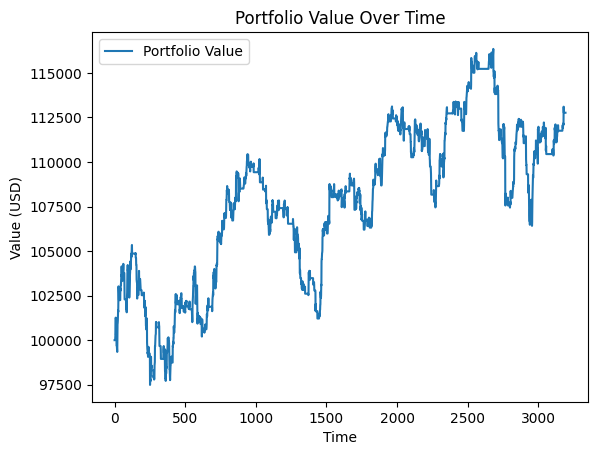

In [9]:
import numpy as np

# Example DataFrame (ensure you have 'Close' prices and predictions)
# df should already have 'Close' prices and model 'Label' predictions
capital = 100000  # Initial capital in USD
position = 0      # Number of shares held
portfolio_value = capital  # Initial portfolio value

df['Portfolio_Value'] = np.nan  # To track portfolio value over time

# Simulate trading
for i in range(len(df)):
    price = df.loc[i, 'Close']
    prediction = df.loc[i, 'Label']  # Predicted label ("Buy", "Sell", "Keep")
    
    if prediction == 'Buy' and position == 0:
        # Buy all-in
        position = capital / price
        capital = 0
    elif prediction == 'Sell' and position > 0:
        # Sell everything
        capital = position * price
        position = 0
    # Update portfolio value
    portfolio_value = capital + position * price
    df.loc[i, 'Portfolio_Value'] = portfolio_value

# Final return rate
final_value = portfolio_value
return_rate = (final_value - 100000) / 100000

print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Return Rate: {return_rate:.2%}")

# Plot portfolio value over time
import matplotlib.pyplot as plt

df['Portfolio_Value'] = df['Portfolio_Value'].fillna(method='ffill')  # Fill forward missing values
plt.plot(df['Portfolio_Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Value (USD)')
plt.legend()
plt.show()


In [10]:
# Buy-and-Hold Strategy
initial_price = df['Close'].iloc[0]
final_price = df['Close'].iloc[-1]

buy_and_hold_return = (final_price - initial_price) / initial_price
print(f"Buy-and-Hold Return Rate: {buy_and_hold_return:.2%}")

# Compare with your model's return
model_outperformance = return_rate - buy_and_hold_return
print(f"Model Outperformance vs. Buy-and-Hold: {model_outperformance:.2%}")


Buy-and-Hold Return Rate: 52.63%
Model Outperformance vs. Buy-and-Hold: -39.86%
